In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import os
os.getcwd()

'/Users/shreyas/Desktop/Shreyas/tutorial_inverse_problem'

https://en.wikipedia.org/wiki/Broyden%E2%80%93Fletcher%E2%80%93Goldfarb%E2%80%93Shanno_algorithm


In [3]:
nx = 30

def read_state(file_state = 'state.txt'):
    
    M = np.zeros((nx+1,), dtype = float)
    b = np.zeros((nx+1,), dtype = float)
    
    with open(file_state, 'r') as reader:
        content = reader.readlines()
        
        for i in range(nx+1):
            M[i] = float(content[i])
            b[i] = float(content[nx+1+i])
        
    return np.concatenate((M, b))

def read_gradient(file_grad = 'gradient.txt'):
    
    Mb = np.zeros((nx+1,), dtype = float)
    bb = np.zeros((nx+1,), dtype = float)
    
    with open(file_grad, 'r') as reader:
        content = reader.readlines()

        for i in range(nx+1):
            Mb[i] = float(content[i])
            bb[i] = float(content[nx+1+i])
        
    return np.concatenate((Mb, bb))

def write_state(state, file_state = 'state.txt'):
    
    if len(state) != 2*(nx+1):
        print("Inputs to write_state maybe of incorrect length")
    
    with open(file_state, 'w') as writer:
        for i in range(2*(nx+1)-1):
            writer.write(f"{state[i]}\n")
        writer.write(f"{state[-1]}")
        
    return None

def eval_gradient(state, file_gradient = 'gradient.txt', file_state = 'state.txt'):
    write_state(state)
    os.system("./adjoint")
    
    gradient = read_gradient(file_grad = file_gradient)
        
    return gradient

def eval_loss(state, file_loss = 'loss_inexact_line_search.txt', file_state = 'state.txt'):
    write_state(state)
    os.system("./forward")
    
    with open(file_loss, 'r') as reader:
        content = reader.readlines()
        J = float(content[0])
        
    return J

os.system("make -f Makefile clean; make -f Makefile")
os.system("make -f Makefile_forward clean; make -f Makefile_forward")

0

In [4]:
x = np.arange(nx+1)
M_true = 0.004 - 0.0002*x
b_true = 1.0 - 0.0001*x

write_state(np.concatenate((0.01*np.ones((nx+1,)), np.ones((nx+1,)))))

read_state()


array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01,
       0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ])

In [5]:
def BFGS_update_matrix(B, inv_B, y, s):
    
    B_times_s = np.matmul(B, s)
    y_dot_s = np.inner(y, s)
    
    ##### UPDATE B #####
    B_new = B + np.outer(y,y)/y_dot_s - np.outer(B_times_s, B_times_s)/np.inner(s, B_times_s)
    
    ##### UPDATE INV_B #####
    I = np.eye(B.shape[0], dtype = float)
    
    left = I - np.outer(s, y)/ y_dot_s
    right = I - np.outer(y, s)/ y_dot_s
    inv_B_new = np.matmul(left, np.matmul(inv_B, right)) + np.outer(s, s) / y_dot_s
    
    eigs, _ = np.linalg.eig(B_new)
    
    for eig in eigs:
        if(eig <= 0):
            print("Hessian not Positive definite")
            break
        else:
            pass
        
    return B_new, inv_B_new

def search_alpha(state, gradient, rho, alpha = 1, c1 = 1e-4, c2 = 0.9):
    while True:
        
        f_old = eval_loss(state)
        f_new = eval_loss(state+alpha*rho)
        
        gradient_new = eval_gradient(state+alpha*rho)
        #print((f_new - f_old) - c1*alpha*np.inner(rho, gradient), np.inner(rho, gradient_new) -  c2*np.inner(rho, gradient))
        if (f_new - f_old) <= c1*alpha*np.inner(rho, gradient) and np.inner(rho, gradient_new) >=  c2*np.inner(rho, gradient): 
            break
        else:
            alpha = alpha/2
            
    return alpha



https://scicomp.stackexchange.com/questions/11323/effect-of-initial-guess-b-approximate-hessian-on-bfgs-algorithm

In [6]:
##### INITIAL GUESS #####
M = 0.001*np.ones((nx+1,))
b = 0.5*np.ones((nx+1,))

write_state(np.concatenate((M, b)))

MAX_ITERS = 12

state = read_state()

gradient = eval_gradient(state)

B = np.diagflat(np.concatenate((np.ones(nx+1), 0.1*np.ones(nx+1))))
B_inv = np.linalg.inv(B)

M_list = []
b_list = []
for iteration in range(MAX_ITERS):

    state_old = np.copy(state)
    gradient_old = np.copy(gradient)
    
    rho = -np.matmul(B_inv, gradient_old)
    alpha = search_alpha(state_old, gradient_old, rho)
    
    s = alpha*rho
    state = state_old + s
    gradient = eval_gradient(state)
    y = gradient - gradient_old
        
    if iteration == 0:
        
        pass
        
    elif iteration == 1 or np.inner(y, s) <= 0:
        
        if (iteration == 1): print("Set/Reset initial guess")
        #print(f"B reset iter {iteration}")
        B =  np.inner(y, y) / np.abs(np.inner(y, s)) * np.eye(2*(nx+1), dtype = float)
        B_inv =  np.abs(np.inner(y, s)) / np.inner(y, y) * np.eye(2*(nx+1), dtype = float)
        
    else:
            
        B, B_inv = BFGS_update_matrix(B, B_inv, y, s)
        
    M_list.append(state[:nx+1])
    b_list.append(state[nx+1:2*(nx+1)])
    
    print(f"iter = {iteration+1}; Loss = {eval_loss(state)}")
    

iter = 1; Loss = 707.7671740200067
Set/Reset initial guess
iter = 2; Loss = 1.8340323871868536
iter = 3; Loss = 0.7579386963209628
iter = 4; Loss = 0.5824809393771267
iter = 5; Loss = 0.573316138795839
iter = 6; Loss = 0.24105546826849245
iter = 7; Loss = 0.22558707124758884
iter = 8; Loss = 0.19870817395606416
iter = 9; Loss = 0.06910364924496544
iter = 10; Loss = 0.03784573100285722
iter = 11; Loss = 0.03448027464087923
iter = 12; Loss = 0.029447013617579215


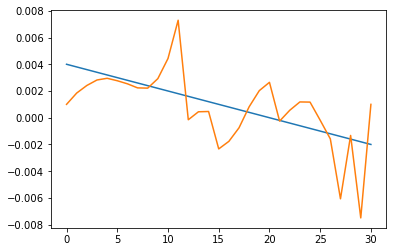

In [7]:
plt.plot(M_true)
plt.plot(state[:nx+1])

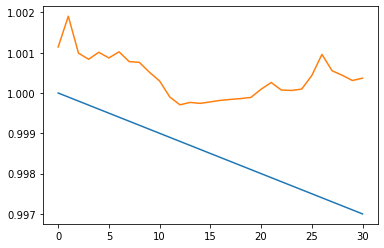

In [8]:
plt.plot(b_true)
plt.plot(state[nx+1:])

https://www.stat.cmu.edu/~ryantibs/convexopt-F16/lectures/quasi-newton.pdf           
https://www.stat.cmu.edu/~ryantibs/convexopt-F18/lectures/quasi-newton.pdf

In [9]:
def L_BFGS_update(k, state_k, y_list, s_list, m):
    
    q = - eval_gradient(state_k)
    
    alpha = np.zeros(k)
    
    for i in range(k-1, np.maximum(k-m, 0) - 1, -1):
        
        alpha[i] = np.inner(s_list[i-np.maximum(k-m, 0)], q)/np.inner(y_list[i-np.maximum(k-m, 0)], s_list[i-np.maximum(k-m, 0)])
        q = q - alpha[i]*y_list[i-np.maximum(k-m, 0)]
        
    p = np.inner(np.array(y_list[-1]), np.array(s_list[-1]))/np.inner(np.array(y_list[-1]), np.array(y_list[-1]))*q
    
    for i in range(np.maximum(k-m, 0), k):
        beta = np.inner(y_list[i - np.maximum(k-m, 0)], p)/np.inner(y_list[i - np.maximum(k-m, 0)], s_list[i - np.maximum(k-m, 0)])
        #print(i, k-m, np.maximum(k-m, 0))
        p = p + (alpha[i] - beta)*s_list[i - np.maximum(k-m, 0)]
        
    return np.array(p)

def manage_y_s_lists(m, y_list, s_list, y, s):
    if len(y_list) < m and len(s_list) < m and len(y_list) == len(s_list):
        y_list.append(np.array(y))
        s_list.append(np.array(s))
    elif len(y_list) == m and len(s_list) == m:
        y_list.pop(0)
        s_list.pop(0)
        y_list.append(np.array(y))
        s_list.append(np.array(s))
        
    return y_list, s_list
        

In [10]:
##### INITIAL GUESS #####
M = 0.001*np.ones((nx+1,))
b = 0.5*np.ones((nx+1,))

write_state(np.concatenate((M, b)))

MAX_ITERS = 22



state = read_state()

gradient = eval_gradient(state)

B = np.diagflat(np.concatenate((np.ones(nx+1), 0.1*np.ones(nx+1))))
B_inv = np.linalg.inv(B)

s_list = []
y_list = []

m = 10

M_list_LBFGS = []
b_list_LBFGS = []

for iteration in range(MAX_ITERS):
    state_old = np.copy(state)
    gradient_old = np.copy(gradient)
    
    if iteration == 0:
        rho = -np.matmul(B_inv, gradient_old)
        
    else: 

        rho = L_BFGS_update(iteration, state_old, y_list, s_list, m)
        
    alpha = search_alpha(state_old, gradient_old, rho)
    s = alpha*rho
    state = state_old + s
    gradient = eval_gradient(state)
    y = gradient - gradient_old
        
    y_list, s_list = manage_y_s_lists(m, y_list, s_list, y, s)
    
    M_list_LBFGS.append(state[:nx+1])
    b_list_LBFGS.append(state[nx+1:2*(nx+1)])
    
    print(f"iter = {iteration+1}; Loss = {eval_loss(state)}")
    

iter = 1; Loss = 707.7671740200067
iter = 2; Loss = 400.6485036810843
iter = 3; Loss = 105.90371340985897
iter = 4; Loss = 7.882646627598739
iter = 5; Loss = 3.7680773541971533
iter = 6; Loss = 2.8824593814948667
iter = 7; Loss = 1.2183148884016133
iter = 8; Loss = 0.9174564425541337
iter = 9; Loss = 0.7548619060007249
iter = 10; Loss = 0.34578987428909824
iter = 11; Loss = 0.0931207220805799
iter = 12; Loss = 0.09146323671375683
iter = 13; Loss = 0.08233872592776781
iter = 14; Loss = 0.06750163004983548
iter = 15; Loss = 0.0222377422601204
iter = 16; Loss = 0.021632679487165657
iter = 17; Loss = 0.02115003091528225
iter = 18; Loss = 0.019969491445571152
iter = 19; Loss = 0.015854867927064708
iter = 20; Loss = 0.014747646605758485
iter = 21; Loss = 0.013345402747475466
iter = 22; Loss = 0.010583868982521397


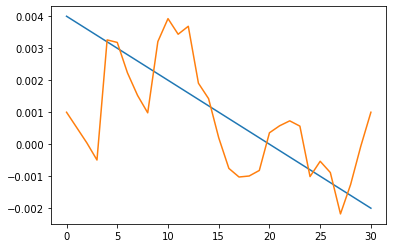

In [11]:
plt.plot(M_true)
plt.plot(state[:nx+1])

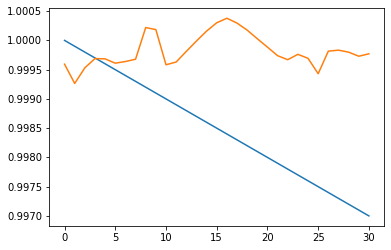

In [12]:
plt.plot(b_true)
plt.plot(state[nx+1:])

https://gregorygundersen.com/blog/2019/01/17/randomized-svd/

In [13]:

def write_vector_for_A_action(vector, filename = "direction_A_action.txt"):

    with open(filename, 'w') as writer:
        for i in range(2*(nx+1)):
            writer.write(f"{vector[i]}\n")        
    return None
        
def write_vector_for_AT_action(vector, filename = "direction_AT_action.txt"):
    
    with open(filename, 'w') as writer:
        for i in range(nx+1):
            writer.write(f"{vector[i]}\n")        
    return None

def read_vector_from_A_action(length = nx+1, filename = "A_action.txt"):

    vector = np.zeros((length,), dtype = float)
    
    with open(filename, 'r') as reader:
        content = reader.readlines()
        for i in range(length):
            vector[i] = float(content[i])
    return vector
        
def read_vector_from_AT_action(length = 2*(nx+1), filename = "AT_action.txt"):
    
    vector = np.zeros((length,), dtype = float)
    
    with open(filename, 'r') as reader:
        content = reader.readlines()
        for i in range(length):
            vector[i] = float(content[i])
    return vector

def action_A(vector):
    write_vector_for_A_action(vector)
    os.system("./A_action")
    answer = read_vector_from_A_action()
    return answer

def action_AT(vector):
    write_vector_for_AT_action(vector)
    os.system("./AT_action")
    answer = read_vector_from_AT_action()
    return answer

def hessian_misfit_action(vector, R_inv = np.eye(31)):
    answer = action_A(vector)
    answer = np.matmul(R_inv, answer)
    answer = action_AT(answer)
    
    return answer

def sqrt_B(B):
    D, V = np.linalg.eig(B)
    sqrt_B = np.matmul(V, np.diag(D**0.5))
    sqrt_B = np.matmul(sqrt_B, V.T)
    
    return sqrt_B
    
    
def prior_preconditioned_hessian_misfit_action(vector, B = 0.01*np.eye(2*(nx+1))):
    answer = np.matmul(sqrt_B(B), vector)
    answer = hessian_misfit_action(answer)

    answer = np.matmul(sqrt_B(B).T, answer)
    
    return answer

def randomized_EVD(k, dim_w = 2*(nx+1), p = 0):
    
    for i in range(k):
        w = np.random.normal(size=(dim_w,))
        y = prior_preconditioned_hessian_misfit_action(w)

        
        if (i > 0):
            q_tilde = np.eye(y.shape[0]) - np.matmul(Q[:,:i], Q[:,:i].T)
            q_tilde = np.matmul(q_tilde, y)
        else: 
            q_tilde = np.copy(y)
            Q = np.zeros((y.shape[0],k))
        
        q = q_tilde / np.linalg.norm(q_tilde)
        
        Q[:,i] = q.T
        
    C = np.zeros((k, k))
    for i in range(k):
        canonical_basis_vector = np.eye(k, dtype = 'float')[:,i]
        AT_Rinv_A_Q_canonical = prior_preconditioned_hessian_misfit_action(np.matmul(Q, canonical_basis_vector))
        C[:,i] = np.matmul(Q.T, AT_Rinv_A_Q_canonical)
        
    D, V = np.linalg.eig(C)
    
    V = np.matmul(Q, V)
    
    A_gauss_newton = np.matmul(np.matmul(V, np.diag(D)), V.T)
    return C, D, V, A_gauss_newton, Q

os.system("make clean; make -f Makefile_A_action")
os.system("make clean; make -f Makefile_AT_action")

0

In [14]:
k = 14
C, D, V, GN_hessian, Q = randomized_EVD(k)

In [15]:
B = 0.01*np.eye(2*(nx+1))

learnings = np.zeros(B.shape)
for i in range(k):
    learnings = learnings + D[i]/(D[i]+1)*np.outer(np.matmul(sqrt_B(B),V[:,i]), np.matmul(sqrt_B(B),V[:,i]))
    
P = B - learnings

B, P

(array([[0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.01, 0.  , ..., 0.  , 0.  , 0.  ],
        [0.  , 0.  , 0.01, ..., 0.  , 0.  , 0.  ],
        ...,
        [0.  , 0.  , 0.  , ..., 0.01, 0.  , 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.01, 0.  ],
        [0.  , 0.  , 0.  , ..., 0.  , 0.  , 0.01]]),
 array([[ 1.00000000e-02,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  9.77481311e-03, -2.82349348e-04, ...,
         -4.80153538e-08,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00, -2.82349348e-04,  9.58653805e-03, ...,
          3.80339978e-07,  0.00000000e+00,  0.00000000e+00],
        ...,
        [ 0.00000000e+00, -4.80153538e-08,  3.80339978e-07, ...,
          9.99858634e-03,  0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  1.00000000e-02,  0.00000000e+00],
        [ 0.00000000e+00,  0.0000000

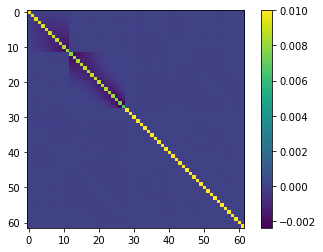

In [16]:
plt.imshow(P)
plt.colorbar()

In [17]:
np.diag(P)

array([0.01      , 0.00977481, 0.00958654, 0.00939838, 0.00927863,
       0.00918873, 0.00908569, 0.00896457, 0.00880855, 0.0086212 ,
       0.00838919, 0.00810566, 0.00792715, 0.00819766, 0.00845293,
       0.00862378, 0.00873084, 0.00880836, 0.00878293, 0.00875351,
       0.00864949, 0.008556  , 0.00846299, 0.00832915, 0.00821963,
       0.00795727, 0.00742022, 0.00640507, 0.01      , 0.01      ,
       0.01      , 0.0099868 , 0.0099493 , 0.00997358, 0.00994756,
       0.00997564, 0.0099774 , 0.0099478 , 0.00996331, 0.0099667 ,
       0.00998876, 0.00997827, 0.00996181, 0.00995539, 0.00997352,
       0.0099689 , 0.00995601, 0.00994846, 0.00997346, 0.00993782,
       0.00996097, 0.0099616 , 0.00995887, 0.00995176, 0.00995584,
       0.00996133, 0.00994523, 0.00994482, 0.00995489, 0.00999859,
       0.01      , 0.01      ])

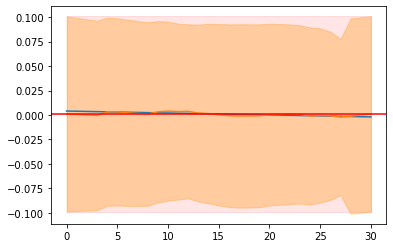

In [18]:
plt.plot(x, M_true, label = "True M")
plt.plot(x, state[:nx+1], label = "Predicted M")
plt.axhline(0.001, label="Initial guess", color = "red")
plt.fill_between(x, state[:nx+1] - np.diag(P)[:nx+1]**0.5, state[:nx+1] + np.diag(P)[:nx+1]**0.5, alpha = 0.3, color = "orange")

plt.fill_between(x, 0.001 - np.diag(B)[:nx+1]**0.5, 0.001 + np.diag(B)[:nx+1]**0.5, alpha = 0.1, color = "red")

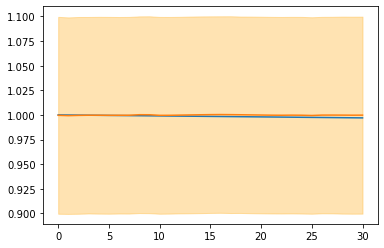

In [19]:
plt.plot(x, b_true, label = "True M")
plt.plot(x, state[nx+1:], label = "Predicted M")
# plt.axhline(0.5, label="Initial guess", color = "red")
plt.fill_between(x, state[nx+1:] - np.diag(P)[nx+1:]**0.5, state[nx+1:] + np.diag(P)[nx+1:]**0.5, alpha = 0.3, color = "orange")

# plt.fill_between(x, 0.5 - np.diag(B)[:nx+1]**0.5, 0.5 + np.diag(B)[:nx+1]**0.5, alpha = 0.1, color = "red")

In [20]:
D

array([3.96205985e+02, 9.63632164e+00, 6.99107795e+00, 1.03921862e+00,
       2.79104095e-01, 2.27508385e-01, 1.07189622e-01, 5.41303023e-02,
       3.49575506e-02, 2.72789350e-02, 1.22577613e-02, 1.45898330e-02,
       1.62417541e-02, 1.75167011e-02])